# CSP based classification

In this notebook, we explore Common Spatial Pattern (CSP) based classification algorithms.
CSP is a signal processing technique and converts the RAW EEG data from previous notebooks to more information carrying features.
These features can then be fed to more classical ML models such as Support Vector Machines (SVMs).

This experimental notebook uses a database provided by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data, which gathered its functions from the experiments performed in previous notebooks. Since the original dataset by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211) was provided in MatLAb files, FIF files for the python MNE datatypes are made available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

We rely in part on the [MNE provided tutorials](https://mne.tools/dev/auto_examples/decoding/index.html) for this notebook.

## Table of Contents

- Checking requirements
  - Correct anaconda environment
  - Correct module access
  - Correct file access
- Loading in data
- Fixed window classification: Single trial | CSP + LDA | Binary left-right MI task
- Fixed window classification: Single trial | CSP + LDA | three class MI task
- Fixed window classification: Multi trial | CSP + LDA | three class MI task

<hr><hr>

## Checking requirements

### Correct anaconda environment

The `bci-master-thesis` anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [36]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following codeblock will load in all required modules.

In [37]:
####################################################
# LOADING MODULES
####################################################

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")
from mne.decoding import CSP

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score, train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Scikit-learn version (1.0.2 recommended): 1.0.2
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this experimental notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`.

In [38]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr><hr>

## Loading in data

In this step, we load the data. The data is provided as `.mat` files and thus originally meant for use with MATLAB. 
However, thanks to the written `CLA_dataset` util file we can easily get the MNE raw data from it, FIF files of which are also provided on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

Please specify the filename in the below code block. For more info on which variants are available, please look at the `bci-master-thesis/code/data/CLA/README.md` file.

Remember the meaning of the markers:
- 0: “blank” or nothing is displayed in eGUI
    - Can be seen as a break between stimuli, thus random EEG data that should probably be ignored
- 1: Left hand action
    - EEG data for MI of the left hand
- 2: Right hand action
    - EEG data for MI of the right hand
- 3: Passive/neutral
    - EEG data for MI of neither left nor right hand but 'focused'
- 91: inter-session rest break period
- 92: experiment end
- 99: initial relaxation period

In [39]:
####################################################
# LOADING RAW MNE DATA AND EPOCS
####################################################

# You can specify the data file to use here, per default it is CLASubjectB1512153StLRHand
subject = "C"

# Load RAW MNE
mne_raws = CLA_dataset.get_raw_mne_data_for_subject("C")
mne_raw = mne_raws[0]
print(f"Loaded MNE raw for subject {subject}: {len(mne_raws)} files, first file: \n")
display(mne_raw)



Loaded MNE raw for subject C: 3 files, first file: 



<Raw | CLASubjectC1511263StLRHand_raw.fif, 21 x 666800 (3334.0 s), ~37 kB, data not loaded>

<hr><hr>

## Fixed window classification: Single trial | CSP + LDA | Binary left-right MI task

We start with fixed window epochs for training and testing and using binary on left and right MI task only.
This is a naive approach but a good stating ground to see if classification is possible at all on the data.



In [40]:
####################################################
# PREPPING THE DATA
####################################################

# Band-pass filter RAW data
mne_raw_filtered = mne_raw.copy()
mne_raw_filtered.load_data()
mne_raw_filtered.filter(0.1, 40)
print(f"Band-pass filtered RAW data\n")
display(mne_raw_filtered)

# Limit to binary for now
mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw_filtered)['task/left', 'task/right']
mne_fixed_window_epochs.load_data()
print(f"Loaded binary epochs for fixed window band-pass filtered RAW:\n")
display(mne_fixed_window_epochs)

# NOTE: labels should be integers!
labels = mne_fixed_window_epochs.events[:, -1]
print(f"Extracted labels from epochs: {labels[:10]}")

Reading 0 ... 666799  =      0.000 ...  3333.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (33.005 sec)

Band-pass filtered RAW data



<Raw | CLASubjectC1511263StLRHand_raw.fif, 21 x 666800 (3334.0 s), ~106.9 MB, data loaded>

Not setting metadata
960 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 960 events and 281 original time points ...
0 bad epochs dropped
Loaded binary epochs for fixed window band-pass filtered RAW:



Number of events,636
Events,task/left: 322task/right: 314
Time range,-0.200 – 1.200 sec
Baseline,-0.200 – 0.000 sec


Extracted labels from epochs: [1 2 1 1 2 2 2 1 1 2]


Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 21 dim * 3.5e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 21 dim * 3.7e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.
Classification accuracy: 0.9265625


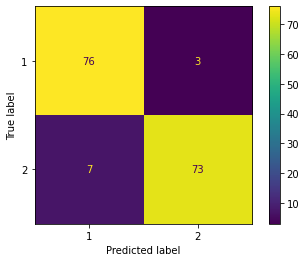

Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 21 dim * 4.1e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 21 dim * 4.2e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.


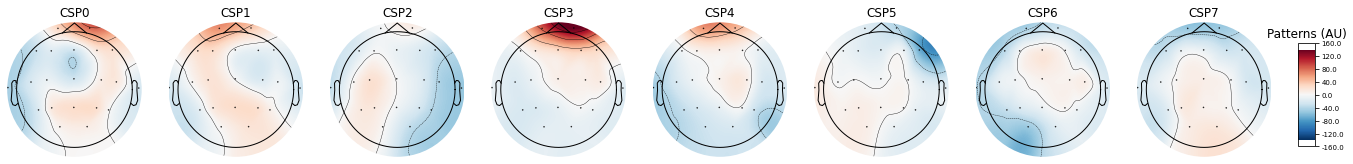

In [41]:
####################################################
# FIXED WINDOW: CSP + LDA
####################################################

# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
mne_fixed_window_epochs_data = mne_fixed_window_epochs.copy().crop(tmin=0, tmax=0.6).get_data()
cv = ShuffleSplit(5, test_size=0.2, random_state=98)
cv_split = cv.split(mne_fixed_window_epochs_data)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=8, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, mne_fixed_window_epochs_data, labels, cv=cv, n_jobs=-1, error_score='raise')



# Show CM for one model
X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, labels, random_state=98)
clf.fit(X_train, y_train)

# Printing the results
print(f"Classification accuracy: {np.mean(scores)}")
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.show()

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(mne_fixed_window_epochs_data, labels)
csp.plot_patterns(mne_fixed_window_epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
plt.show()

<hr><hr>

## Fixed window classification: Single trial | CSP + LDA | three class MI task

We now use all three MI tasks but still limit ourself to single trials and fixed windows.



In [42]:
####################################################
# PREPPING THE DATA
####################################################

# Band-pass filter RAW data
mne_raw_filtered = mne_raw.copy()
mne_raw_filtered.load_data()
mne_raw_filtered.filter(0.1, 40)
print(f"Band-pass filtered RAW data\n")
display(mne_raw_filtered)

# Use all three MI tasks
mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw_filtered)
mne_fixed_window_epochs.load_data()
print(f"Loaded epochs for fixed window band-pass filtered RAW:\n")
display(mne_fixed_window_epochs)

# NOTE: labels should be integers!
labels = mne_fixed_window_epochs.events[:, -1]
print(f"Extracted labels from epochs: {labels[:10]}")

Reading 0 ... 666799  =      0.000 ...  3333.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (33.005 sec)

Band-pass filtered RAW data



<Raw | CLASubjectC1511263StLRHand_raw.fif, 21 x 666800 (3334.0 s), ~106.9 MB, data loaded>

Not setting metadata
960 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 960 events and 281 original time points ...
0 bad epochs dropped
Loaded epochs for fixed window band-pass filtered RAW:



Number of events,960
Events,task/left: 322task/neutral: 324task/right: 314
Time range,-0.200 – 1.200 sec
Baseline,-0.200 – 0.000 sec


Extracted labels from epochs: [1 2 1 3 1 3 3 2 3 2]


Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 21 dim * 3.6e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 21 dim * 3.6e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00017 (2.2e-16 eps * 21 dim * 3.7e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.
Classification accuracy: 0.7749999999999999


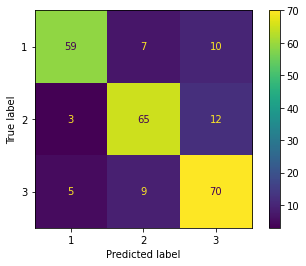

Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 21 dim * 4.1e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.0002 (2.2e-16 eps * 21 dim * 4.2e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00021 (2.2e-16 eps * 21 dim * 4.4e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.


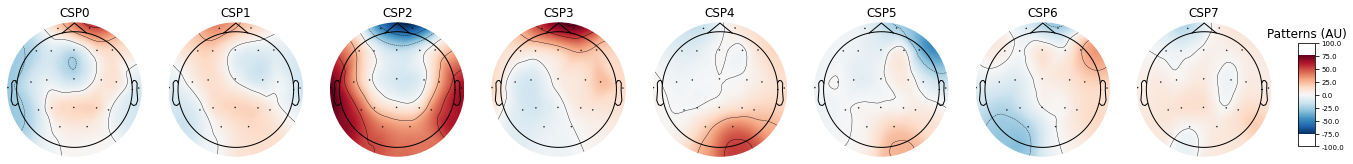

In [43]:
####################################################
# FIXED WINDOW: CSP + LDA
####################################################

# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
mne_fixed_window_epochs_data = mne_fixed_window_epochs.copy().crop(tmin=0, tmax=0.6).get_data()
cv = ShuffleSplit(5, test_size=0.2, random_state=98)
cv_split = cv.split(mne_fixed_window_epochs_data)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=8, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, mne_fixed_window_epochs_data, labels, cv=cv, n_jobs=-1, error_score='raise')



# Show CM for one model
X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, labels, random_state=98)
clf.fit(X_train, y_train)

# Printing the results
print(f"Classification accuracy: {np.mean(scores)}")
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.show()

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(mne_fixed_window_epochs_data, labels)
csp.plot_patterns(mne_fixed_window_epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
plt.show()

<hr><hr>

## Fixed window classification: Multi trial | CSP + LDA | three class MI task

Similarly to the previous we now use epochs spread over multiple trials to boost the amount of data we have available but also have more varying data since it is recorded at different times.



In [44]:
####################################################
# PREPPING THE DATA
####################################################

epochs = []
labels = []

for single_mne_raw in mne_raws:
    # Band-pass filter RAW data
    mne_raw_filtered = single_mne_raw.copy()
    mne_raw_filtered.load_data()
    mne_raw_filtered.filter(0.1, 40)
    print(f"Band-pass filtered RAW data\n")
    
    # Use all three MI tasks
    mne_fixed_window_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw_filtered)
    mne_fixed_window_epochs.load_data()
    epochs.append(mne_fixed_window_epochs)
    print(f"Loaded epochs for fixed window band-pass filtered RAW")
    
    # NOTE: labels should be integers!
    labels.extend(mne_fixed_window_epochs.events[:, -1])
    print(f"Extracted labels from epochs")
    
mne_fixed_window_epochs = mne.concatenate_epochs(epochs)
print("Concatenated all epochs")
display(mne_fixed_window_epochs)
print(f"Total amount of labels: {len(labels)}")

Reading 0 ... 666799  =      0.000 ...  3333.995 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6601 samples (33.005 sec)

Band-pass filtered RAW data

Not setting metadata
960 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 960 events and 281 original time points ...
0 bad epochs dropped
Loaded epochs for fixed window band-pass filtered RAW
Extracted labels from epochs
Re

C:\Users\Lennert\AppData\Local\Temp\ipykernel_17296\790441154.py:25: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  mne_fixed_window_epochs = mne.concatenate_epochs(epochs)


Number of events,2879
Events,task/left: 965task/neutral: 972task/right: 942
Time range,-0.200 – 1.200 sec
Baseline,-0.200 – 0.000 sec


Total amount of labels: 2879


Computing rank from data with rank=None
    Using tolerance 0.00052 (2.2e-16 eps * 21 dim * 1.1e+11  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00043 (2.2e-16 eps * 21 dim * 9.3e+10  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00071 (2.2e-16 eps * 21 dim * 1.5e+11  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.
Classification accuracy: 0.6211805555555555


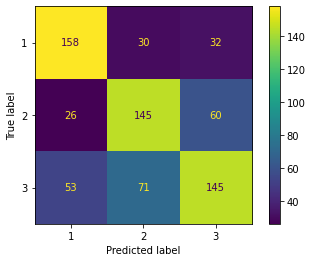

Computing rank from data with rank=None
    Using tolerance 0.0006 (2.2e-16 eps * 21 dim * 1.3e+11  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00048 (2.2e-16 eps * 21 dim * 1e+11  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00073 (2.2e-16 eps * 21 dim * 1.6e+11  max singular value)
    Estimated rank (mag): 21
    MAG: rank 21 computed from 21 data channels with 0 projectors
Reducing data rank from 21 -> 21
Estimating covariance using EMPIRICAL
Done.


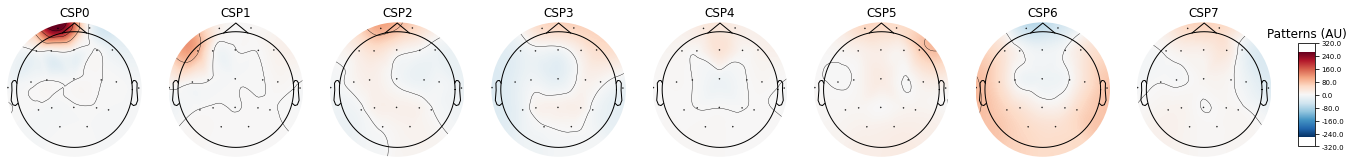

In [45]:
####################################################
# FIXED WINDOW: CSP + LDA
####################################################

# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
mne_fixed_window_epochs_data = mne_fixed_window_epochs.copy().crop(tmin=0, tmax=0.6).get_data()
cv = ShuffleSplit(5, test_size=0.2, random_state=98)
cv_split = cv.split(mne_fixed_window_epochs_data)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=8, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([('CSP', csp), ('LDA', lda)])
scores = cross_val_score(clf, mne_fixed_window_epochs_data, labels, cv=cv, n_jobs=-1, error_score='raise')



# Show CM for one model
X_train, X_test, y_train, y_test = train_test_split(mne_fixed_window_epochs_data, labels, random_state=98)
clf.fit(X_train, y_train)

# Printing the results
print(f"Classification accuracy: {np.mean(scores)}")
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
plt.show()

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(mne_fixed_window_epochs_data, labels)
csp.plot_patterns(mne_fixed_window_epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
plt.show()